In [189]:
# ML Final 

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC



In [190]:
from google.colab import drive 
drive.mount('/content/gdrive/')

# Load dataset
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/bank.csv')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [191]:
df.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [192]:
# ──────────────────────────────────────────
#          Drop Columns
# ──────────────────────────────────────────
print("\n--------------------------- < Initial Columns > ----------------------------")
count = 0
for c in df.columns:
    if (count != 0) & ((count % 7) == 0):
        print(c)
    elif count == len(df.columns):
        print(c)
    else:
        print(c, end=', ')
    count += 1

df2 = df.copy()

df2.drop(['Unnamed: 0', 'contact', 'month', 'day_of_week',
          'duration', 'campaign', 'pdays', 'previous', 'poutcome'], axis=1, inplace=True)
df2.shape


--------------------------- < Initial Columns > ----------------------------
Unnamed: 0, age, job, marital, education, default, housing, loan
contact, month, day_of_week, duration, campaign, pdays, previous
poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, y


(41188, 13)

In [193]:
# ──────────────────────────────────────────
#           One Hot encoding
# ──────────────────────────────────────────
job_one_hot = pd.get_dummies(df2['job'], prefix='job')
marital_one_hot = pd.get_dummies(df2['marital'], prefix='marital')
education_one_hot = pd.get_dummies(df2['education'], prefix='education')
default_one_hot = pd.get_dummies(df2['default'], prefix='default')
housing_one_hot = pd.get_dummies(df2['housing'], prefix='housing')
loan_one_hot = pd.get_dummies(df2['loan'], prefix='loan')

In [194]:
df2.drop(['job','marital','education', 'default', 'housing','loan'], axis=1, inplace=True)
df2.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,1.1,93.994,-36.4,4.857,5191.0,no
1,57,1.1,93.994,-36.4,4.857,5191.0,no
2,37,1.1,93.994,-36.4,4.857,5191.0,no
3,40,1.1,93.994,-36.4,4.857,5191.0,no
4,56,1.1,93.994,-36.4,4.857,5191.0,no


In [195]:
df2 = pd.concat([df2,job_one_hot, marital_one_hot, education_one_hot, default_one_hot,housing_one_hot, loan_one_hot],axis=1)
df2.shape

(41188, 40)

Text(0.5, 1.0, 'emp.var.rate')

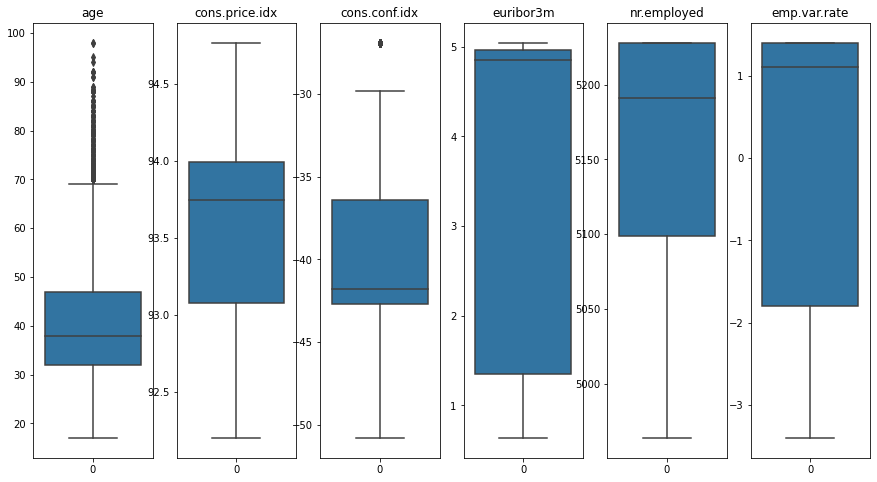

In [196]:
# ──────────────────────────────────────────
#           Visualize the distribution of data
# ──────────────────────────────────────────
f, axes = plt.subplots(ncols = 6, figsize=(15,8))
sns.boxplot(data = df2['age'], ax = axes[0])
axes[0].set_title('age')
sns.boxplot(data = df2['cons.price.idx'], ax = axes[1])
axes[1].set_title('cons.price.idx')
sns.boxplot(data = df2['cons.conf.idx'], ax = axes[2])
axes[2].set_title('cons.conf.idx')
sns.boxplot(data = df2['euribor3m'], ax = axes[3])
axes[3].set_title('euribor3m')
sns.boxplot(data = df2['nr.employed'], ax = axes[4])
axes[4].set_title('nr.employed')
sns.boxplot(data = df2['emp.var.rate'], ax = axes[5])
axes[5].set_title('emp.var.rate')

In [197]:
# ──────────────────────────────────────────
#           Function of getting of outlier index
# ──────────────────────────────────────────
def get_outlier(df=None, column=None, weight=1.5):

  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [198]:
# ──────────────────────────────────────────
#           Remove outlier index
# ──────────────────────────────────────────
age_outlier_idx = get_outlier(df2, 'age', weight= 1.5)
df2.drop(age_outlier_idx, axis=0, inplace=True)

conf_outlier_idx = get_outlier(df2, 'cons.conf.idx', weight= 1.5)
df2.drop(conf_outlier_idx, axis=0, inplace=True)

df2.shape

(40327, 40)

Text(0.5, 1.0, 'emp.var.rate')

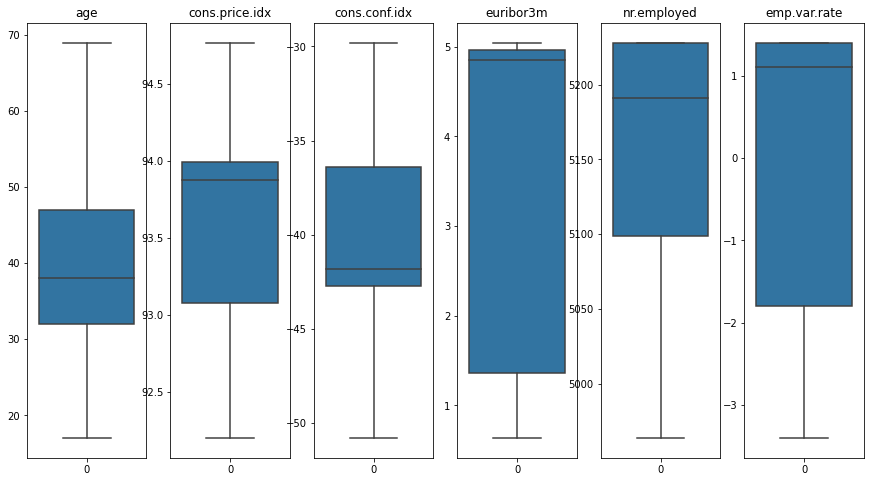

In [199]:
# ──────────────────────────────────────────
#           Visualize the distribution of data after remove outlier index
# ──────────────────────────────────────────
f, axes = plt.subplots(ncols = 6, figsize=(15,8))
sns.boxplot(data = df2['age'], ax = axes[0])
axes[0].set_title('age')
sns.boxplot(data = df2['cons.price.idx'], ax = axes[1])
axes[1].set_title('cons.price.idx')
sns.boxplot(data = df2['cons.conf.idx'], ax = axes[2])
axes[2].set_title('cons.conf.idx')
sns.boxplot(data = df2['euribor3m'], ax = axes[3])
axes[3].set_title('euribor3m')
sns.boxplot(data = df2['nr.employed'], ax = axes[4])
axes[4].set_title('nr.employed')
sns.boxplot(data = df2['emp.var.rate'], ax = axes[5])
axes[5].set_title('emp.var.rate')

In [200]:
df2.loc[df2["y"] == "no","y"] = 0
df2.loc[df2["y"] == "yes","y"] = 1
df2["y"] = df2["y"].astype('int')
df2.head()


,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,56,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,57,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
2,37,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
3,40,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,56,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [201]:
y_idx = df2['y'].unique()

y_count = df2['y'].value_counts()

sum = y_count[0] + y_count[1]
print("yes's ratio = {:.2f}%".format(y_count[1] / sum * 100))
print("no's ratio = {:.2f}%".format(y_count[0] / sum * 100))

yes's ratio = 10.56%
no's ratio = 89.44%


In [202]:
y = df2['y']
X = df2.drop(['y'], axis=1)
X.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,56,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
1,57,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
2,37,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
3,40,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,56,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [203]:
# # ──────────────────────────────────────────
# #               Undersampling
# # ──────────────────────────────────────────

# from collections import Counter
# from imblearn.under_sampling import RandomUnderSampler
# # summarize class distribution
# print(Counter(y))

# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
# # fit and apply the transform
# X_under, y_under = undersample.fit_resample(X, y)

# # summarize class distribution
# print(Counter(y_under))

# X = pd.DataFrame(X_under, columns=X.columns)
# y = y_under

In [204]:
# ──────────────────────────────────────────
#               Normalization
# ──────────────────────────────────────────
scaler = MinMaxScaler()
scaled_x = MinMaxScaler().fit_transform(X)
scaled_x = pd.DataFrame(scaled_x, columns=X.columns, index=list(X.index.values))
scaled_x.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,0.750000,0.9375,0.698753,0.685714,0.957379,0.859735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.769231,0.9375,0.698753,0.685714,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.384615,0.9375,0.698753,0.685714,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.442308,0.9375,0.698753,0.685714,0.957379,0.859735,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.750000,0.9375,0.698753,0.685714,0.957379,0.859735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


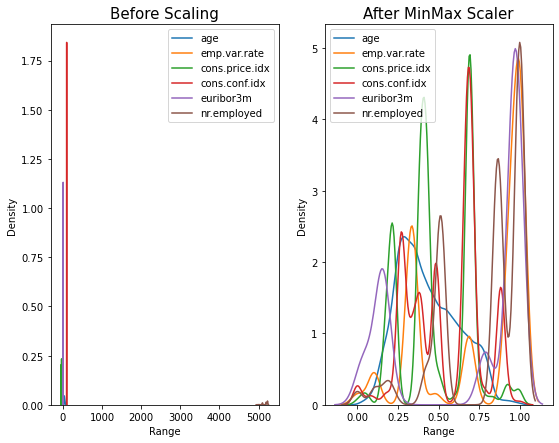

In [205]:

target_names = ['No', 'Yes']

# Visualize Data Normalization with MinMax Scaling
ig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))
ax1.set_title('Before Scaling', size=15)
sns.kdeplot(df2['age'], ax=ax1)
sns.kdeplot(df2['emp.var.rate'], ax=ax1)
sns.kdeplot(df2['cons.conf.idx'], ax=ax1)
sns.kdeplot(df2['cons.price.idx'], ax=ax1)
sns.kdeplot(df2['euribor3m'], ax=ax1)
sns.kdeplot(df2['nr.employed'], ax=ax1)
ax1.legend(['age', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed'])
ax1.set_xlabel('Range')

ax2.set_title('After MinMax Scaler', size=15)
sns.kdeplot(scaled_x['age'], ax=ax2)
sns.kdeplot(scaled_x['emp.var.rate'], ax=ax2)
sns.kdeplot(scaled_x['cons.conf.idx'], ax=ax2)
sns.kdeplot(scaled_x['cons.price.idx'], ax=ax2)
sns.kdeplot(scaled_x['euribor3m'], ax=ax2)
sns.kdeplot(scaled_x['nr.employed'], ax=ax2)
ax2.legend(['age', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed'])
ax2.set_xlabel('Range')

plt.show()

In [206]:
# ──────────────────────────────────────────
#               Split data
# ──────────────────────────────────────────
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, shuffle=True, random_state=0)

kf = KFold(n_splits=5)



----------------- < Decision Tree > -----------------
Accuracy: 0.897
MSE(Mean Square Error):  0.103
F1 Score:  0.875


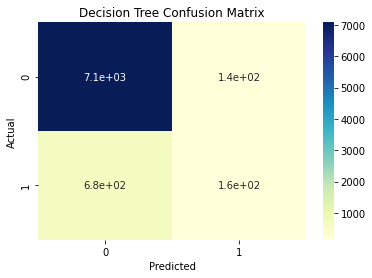


Decision Tree Classification Report
              precision    recall  f1-score   support

          No      0.912     0.980     0.945      7223
         Yes      0.526     0.190     0.279       843

    accuracy                          0.897      8066
   macro avg      0.719     0.585     0.612      8066
weighted avg      0.872     0.897     0.875      8066



In [207]:
# ──────────────────────────────────────────
#               Decision Tree
# ──────────────────────────────────────────
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=0)
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

dt_acc = float(accuracy_score(y_test, y_pred).round(3))
dt_mse = float(metrics.mean_squared_error(y_test, y_pred).round(3))
dt_f1 = float(metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1).round(3))
print('\n\n----------------- < Decision Tree > -----------------')
print("Accuracy:", dt_acc)
print("MSE(Mean Square Error): ", dt_mse)
print("F1 Score: ", dt_f1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.title("Decision Tree Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("\nDecision Tree Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



----------------- < Logistic Regression > -----------------
Best parameters: {'C': 1.0, 'max_iter': 50, 'solver': 'lbfgs'}
Best score: 0.894


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.897
MSE(Mean Square Error):  0.103
F1 Score:  0.863


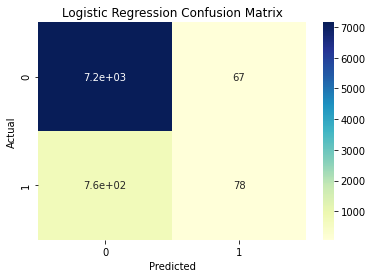


Logistic Regression Classification Report
              precision    recall  f1-score   support

          No      0.903     0.991     0.945      7223
         Yes      0.538     0.093     0.158       843

    accuracy                          0.897      8066
   macro avg      0.721     0.542     0.551      8066
weighted avg      0.865     0.897     0.863      8066



In [208]:
# ──────────────────────────────────────────
#            Logistic Regression
# ──────────────────────────────────────────
logisticRegr = LogisticRegression()
parameters = {'C': [0.1, 1.0, 10.0],
              'solver': ['liblinear', 'lbfgs', 'sag'],
              'max_iter': [50, 100, 200]}

reg_clf = GridSearchCV(logisticRegr, parameters, cv=kf)
reg_clf.fit(X_train, y_train)
print('\n----------------- < Logistic Regression > -----------------')
print("Best parameters:", reg_clf.best_params_)
print("Best score:", reg_clf.best_score_.round(3))

best_reg_clf = LogisticRegression(**reg_clf.best_params_)
best_reg_clf.fit(X_train, y_train)
y_pred = best_reg_clf.predict(X_test)

reg_acc = float(accuracy_score(y_test, y_pred).round(3))
reg_mse = float(metrics.mean_squared_error(y_test, y_pred).round(3))
reg_f1 = float(metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1).round(3))
print("Accuracy:", reg_acc)
print("MSE(Mean Square Error): ", reg_mse)
print("F1 Score: ", reg_f1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("\nLogistic Regression Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3, zero_division=1))



----------------- < Random forest > -----------------
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Best score: 0.8970273249589837
Accuracy: 0.898
MSE(Mean Square Error):  0.102
F1 Score:  0.874


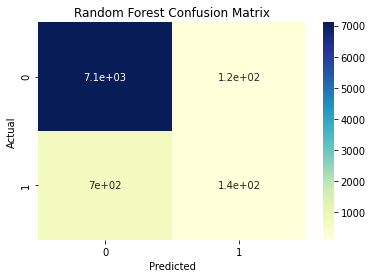


Random Forest Classification Report
              precision    recall  f1-score   support

          No      0.910     0.984     0.945      7223
         Yes      0.544     0.168     0.257       843

    accuracy                          0.898      8066
   macro avg      0.727     0.576     0.601      8066
weighted avg      0.872     0.898     0.874      8066



In [209]:
# ──────────────────────────────────────────
#              Random forest
# ──────────────────────────────────────────
randomforest = RandomForestClassifier()
parameters = {'criterion': ['gini', 'entropy'],
              'n_estimators': [1, 10, 100],
              'max_depth': [1, 10, 100]}

ran_clf = GridSearchCV(randomforest, parameters, cv=kf)
ran_clf.fit(X_train, y_train)
print('\n----------------- < Random forest > -----------------')
print("Best parameters:", ran_clf.best_params_)
print("Best score:", ran_clf.best_score_)

best_ran_clf = RandomForestClassifier(**ran_clf.best_params_)
best_ran_clf.fit(X_train, y_train)
y_pred = best_ran_clf.predict(X_test)

ran_acc = float(accuracy_score(y_test, y_pred).round(3))
ran_mse = float(metrics.mean_squared_error(y_test, y_pred).round(3))
ran_f1 = float(metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1).round(3))
print("Accuracy:", ran_acc)
print("MSE(Mean Square Error): ", ran_mse)
print("F1 Score: ", ran_f1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.title("Random Forest Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("\nRandom Forest Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3, zero_division=1))


----------------- < KNN > -----------------
Best parameters: {'algorithm': 'ball_tree', 'weights': 'uniform'}
Best score: 0.890052964403106


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

The optimal number of neighbors is 17 with 89.6%
Accuracy: 0.894
MSE(Mean Square Error):  0.106
F1 Score:  0.86


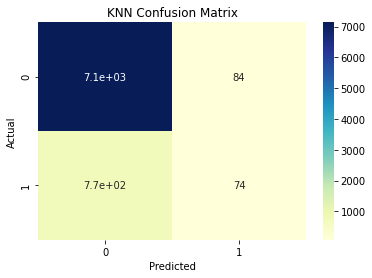


KNN Classification Report
              precision    recall  f1-score   support

          No      0.903     0.988     0.944      7223
         Yes      0.468     0.088     0.148       843

    accuracy                          0.894      8066
   macro avg      0.686     0.538     0.546      8066
weighted avg      0.857     0.894     0.860      8066



In [210]:
# ──────────────────────────────────────────
#                   KNN
# ──────────────────────────────────────────
# Neighbors
neighbors = np.arange(0, 30)
# Create empty list that will hold cv scores
cv_scores = []

from sklearn.neighbors import KNeighborsClassifier

knnClassfier = KNeighborsClassifier()
parameters = {'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

knn_clf = GridSearchCV(knnClassfier, parameters, cv=kf)
knn_clf.fit(X_train, y_train)
print('\n----------------- < KNN > -----------------')
print("Best parameters:", knn_clf.best_params_)
print("Best score:", knn_clf.best_score_)

# Perform 10-fold cross validation on training set for odd values of k:
for k in neighbors:
    k_value = k + 1
    knn = KNeighborsClassifier(n_neighbors=k_value, algorithm='brute', weights='uniform', p=2, metric='euclidean')
    kfold = KFold(n_splits=10, random_state=123)
    scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean() * 100)
    # print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

print("The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k]))


knnClassfier = KNeighborsClassifier(n_neighbors=optimal_k)
knnClassfier.fit(X_train, y_train)
y_pred = knnClassfier.predict(X_test)
knn_acc = float(accuracy_score(y_test, y_pred).round(3))
knn_mse = float(metrics.mean_squared_error(y_test, y_pred).round(3))
knn_f1 = float(metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1).round(3))
print("Accuracy:", knn_acc)
print("MSE(Mean Square Error): ", knn_mse)
print("F1 Score: ", knn_f1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.title("KNN Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("\nKNN Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3, zero_division=1))


----------------- < GradientBoosting > -----------------
Accuracy: 0.898
MSE(Mean Square Error):  0.102
F1 Score:  0.872


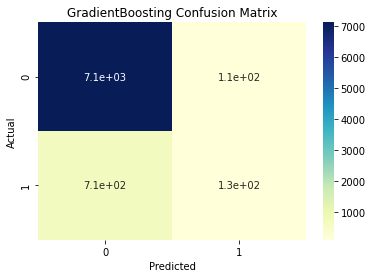


GradientBoosting Classification Report
              precision    recall  f1-score   support

          No      0.909     0.985     0.945      7223
         Yes      0.547     0.159     0.246       843

    accuracy                          0.898      8066
   macro avg      0.728     0.572     0.596      8066
weighted avg      0.871     0.898     0.872      8066



In [211]:
# ──────────────────────────────────────────
#                   GradientBoosting
# ──────────────────────────────────────────
from sklearn.ensemble import GradientBoostingClassifier

gbkClassifier = GradientBoostingClassifier()
gbkClassifier.fit(X_train, y_train)
y_pred = gbkClassifier.predict(X_test)

print('\n----------------- < GradientBoosting > -----------------')

gbk_acc = float(accuracy_score(y_test, y_pred).round(3))
gbk_mse = float(metrics.mean_squared_error(y_test, y_pred).round(3))
gbk_f1 = float(metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1).round(3))
print("Accuracy:", gbk_acc)
print("MSE(Mean Square Error): ", gbk_mse)
print("F1 Score: ", gbk_f1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
plt.title("GradientBoosting Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("\nGradientBoosting Classification Report")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3, zero_division=1))

In [212]:
# # ──────────────────────────────────────────
# #                   SVM
# # ──────────────────────────────────────────
# svclassifier = SVC()
# parameters = {'C': [0.1, 1.0, 10.0],
#               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'gamma': [0.01, 0.1, 1.0, 10.0]}

# svm_clf = GridSearchCV(svclassifier, parameters, cv=kf)
# svm_clf.fit(X_train, y_train)
# print('\n----------------- < SVM > -----------------')
# print("Best parameters:", svm_clf.best_params_)
# print("Best score:", svm_clf.best_score_)

# best_svm_clf = SVC(**svm_clf.best_params_)
# best_svm_clf.fit(X_train, y_train)
# y_pred = best_svm_clf.predict(X_test)

# svm_acc = float(accuracy_score(y_test, y_pred).round(3))
# svm_mse = float(metrics.mean_squared_error(y_test, y_pred).round(3))
# svm_f1 = float(metrics.f1_score(y_test, y_pred, average='weighted', zero_division=1).round(3))
# print("Accuracy:", svm_acc)
# print("MSE(Mean Square Error): ", svm_mse)
# print("F1 Score: ", svm_f1)

# cf_matrix = confusion_matrix(y_test, y_pred)
# sns.heatmap(cf_matrix, annot=True, cmap="YlGnBu")
# plt.title("SVM Confusion Matrix")
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()
# print("\nSVM Classification Report")
# print(classification_report(y_test, y_pred, target_names=target_names, digits=3, zero_division=1))


In [213]:
# ──────────────────────────────────────────
#                   Result
# ──────────────────────────────────────────
print('\n----------------- < Result > -----------------')
data = [
    ['Decision Tree', dt_acc, dt_mse, dt_f1],
    ['Logistic Regression', reg_acc, reg_mse, reg_f1],
    ['Random Forest', ran_acc, ran_mse, ran_f1],
    # ['SVM', svm_acc, svm_mse, svm_f1],
    ['KNN', knn_acc, knn_mse, knn_f1],
    ['GradientBoosting', gbk_acc, gbk_mse, gbk_f1]]
result = pd.DataFrame(data, columns=['Algorithm', 'Accuracy', 'MSE', 'F1-score'])
print(result)



----------------- < Result > -----------------
             Algorithm  Accuracy    MSE  F1-score
0        Decision Tree     0.897  0.103     0.875
1  Logistic Regression     0.897  0.103     0.863
2        Random Forest     0.898  0.102     0.874
3                  KNN     0.894  0.106     0.860
4     GradientBoosting     0.898  0.102     0.872
